In [2]:
# Necessary when connecting to a jupyterhub kernel running on daint via VScode. NOT required otherwise

import os

new_path = '/users/ajayaraj/scratch/tests/qtpyt-tests/AuBDA13/struct2'
os.chdir(new_path)


In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from gpaw import restart
from gpaw.lcao.pwf2 import LCAOwrap
from gpaw.lcao.tools import remove_pbc
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, cutcoupling
from ase.io import read
from qtpyt.basis import Basis
from qtpyt.block_tridiag import graph_partition, greenfunction
from qtpyt.surface.principallayer import PrincipalSelfEnergy
from qtpyt.surface.tools import prepare_leads_matrices
from qtpyt.tools import remove_pbc, rotate_couplings

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)

def plot_atomic_positions_by_species(atoms, element_colors):
    fig, ax = plt.subplots(figsize=(10, 3))
    positions = atoms.positions
    x = positions[:, 0]
    y = positions[:, 1]

    colors = [element_colors[atom.symbol] for atom in atoms]

    ax.scatter(x, y, color=colors, s=300)

    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.text(xi, yi, str(i), color='black', fontsize=9, ha='center', va='center')


    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_title('Atomic Positions by Species')

    plt.show()

In [5]:
GPWDEVICEDIR = 'dft/device/'
BRIDGE_SPECIES = ("N", "C", "H")
GPWLEADSDIR = 'dft/leads/'

In [6]:
lowdin = True
cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)
gpwfile = f'{cc_path}/scatt.gpw'

atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()
H_lcao -= fermi * S_lcao


Condition number: 2.7e+04


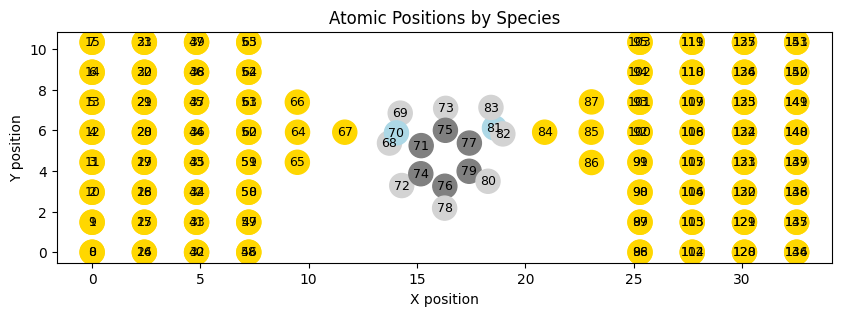

In [7]:
element_colors = {
    "Au": "gold",
    "C": "gray",
    'H': 'lightgray',
    'N': 'lightblue'
}

plot_atomic_positions_by_species(atoms, element_colors)

In [8]:
SUBDIAG_SPECIES = ("C")
subdiag_indices = get_species_indices(atoms,SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)
H_sub_device = rotate_matrix(H_lcao, Usub)[None,...]
S_sub_device = rotate_matrix(S_lcao, Usub)[None,...]

basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

In [9]:
active = {'C':[3,6,7,10,12]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

active_set = set(index_active_region)
index_inactive_region = [idx for idx in index_subdiag_region if idx not in active_set]
index_inactive_region = list(index_inactive_region)

In [9]:
active = {'C':[3]} #,6,7,10,12]}
idxlist = []
M_a = np.cumsum(np.insert(nao_a[:-1], 0, 0))
for kind, idx in active.items():
    for a in atoms.symbols.search(kind):
        for i in idx:
            idxlist.append(M_a[a] + i)
idxlist.sort()
print(idxlist)
print(idxlist.shape)

[1142 1165 1178 1191 1204 1222]
(6,)


In [11]:
external_C_indices = [71, 77]
internal_C_indices = [74, 75, 76, 79]
kind = 'C'
active_ext_C = {kind: [3, 6, 7, 10, 12]}
active_int_C = {kind: [3, 6, 10, 12]}

search_result = atoms.symbols.search(kind)
M_a = np.cumsum(np.insert(nao_a[:-1], 0, 0))

idxlist = []

for a in search_result:
    if a in external_C_indices:
        idxlist.extend(M_a[a] + np.array(active_ext_C[kind]))
    elif a in internal_C_indices:
        idxlist.extend(M_a[a] + np.array(active_int_C[kind]))


idxlist.sort()

print(idxlist)

[638, 641, 642, 645, 647, 661, 664, 668, 670, 674, 677, 681, 683, 687, 690, 694, 696, 700, 703, 704, 707, 709, 718, 721, 725, 727]


## Automate the retreival of blocks

In [11]:
from gpaw.lcao.tools import get_bfi


In [15]:
H_flat = H_sub_device[0]

atoms = calc.atoms.symbols.search(kind)
blocks = [get_bfi(calc, [c]) for c in atoms]

fermi = round(fermi,1)
original_index = []
for block in blocks:
    # print(block)

    submatrix = H_flat[np.ix_(block, block)]
    submatrix = submatrix.round(1)

    diff = np.abs(submatrix - fermi)
    min_index = np.unravel_index(np.argmin(diff, axis=None), submatrix.shape)

    original_index.append(block[min_index[0]])
    print(diff)

print(f"Original indices: {original_index}")


[[20.1  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3]
 [ 4.3 15.6  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3]
 [ 4.3  4.3 14.1  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3]
 [ 4.3  4.3  4.3  7.4  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3]
 [ 4.3  4.3  4.3  4.3  0.5  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3]
 [ 4.3  4.3  4.3  4.3  4.3  0.6  4.3  4.3  4.3  4.3  4.3  4.3  4.3]
 [ 4.3  4.3  4.3  4.3  4.3  4.3  7.   4.3  4.3  4.3  4.3  4.3  4.3]
 [ 4.3  4.3  4.3  4.3  4.3  4.3  4.3  7.3  4.3  4.3  4.3  4.3  4.3]
 [ 4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3 13.2  4.3  4.3  4.3  4.3]
 [ 4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3 13.8  4.3  4.3  4.3]
 [ 4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3 19.8  4.3  4.3]
 [ 4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3 19.9  4.3]
 [ 4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3 20. ]]
[[19.   4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3  4.3]
 [ 4.3 13.7  4.3  4.3  4.3  4.3  4.3  4.3  4.3 

In [ ]:
print(fermi)

4.3
